In [ ]:
# braintorch

# !git clone https://github.com/Pangpuriye-House-SS4/braintorch.git

In [1]:
from braintorch.dataset import SignalDataset, SignalTestDataset
from braintorch.utils import baseline_snip, kurtosis_ica_method
from braintorch.vis import visualtize_signals

dataset = SignalDataset(
    "brain-motor-imagery-classification/train/train",
    baseline_snip,
    tans_segment_theory=0,
    acceptable_loss_sample=5,
    apply_ica=True,
)

100%|██████████| 166/166 [02:41<00:00,  1.03it/s]


In [2]:
from scipy.signal import butter, lfilter

def butter_bandpass(lowcut, highcut, fs, order=5):
    return butter(order, [lowcut, highcut], fs=fs, btype='band')

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [4]:
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')
import numpy as np


nub_x = []
y = []
for segment, label in tqdm(dataset):
    segment = segment.astype(np.float64)
    signals = []
    for channel in range(segment.shape[1]):
        signals.append(butter_bandpass_filter(segment[:, channel], 5, 27, 250))

    sigals = np.vstack(signals).T
    
    nub_x.append(sigals.swapaxes(1,0))#segment.swapaxes(1,0))
    y.append(label)


100%|██████████| 2967/2967 [00:03<00:00, 798.49it/s]


In [5]:
x = np.stack(nub_x, axis=0)
x = x[:, :8, :1750]
y = np.array(y)
y = y.flatten()
print(x.shape,y.shape)

(2967, 8, 1750) (2967,)


In [6]:
y[1]

110

In [7]:
import matplotlib.pyplot as plt

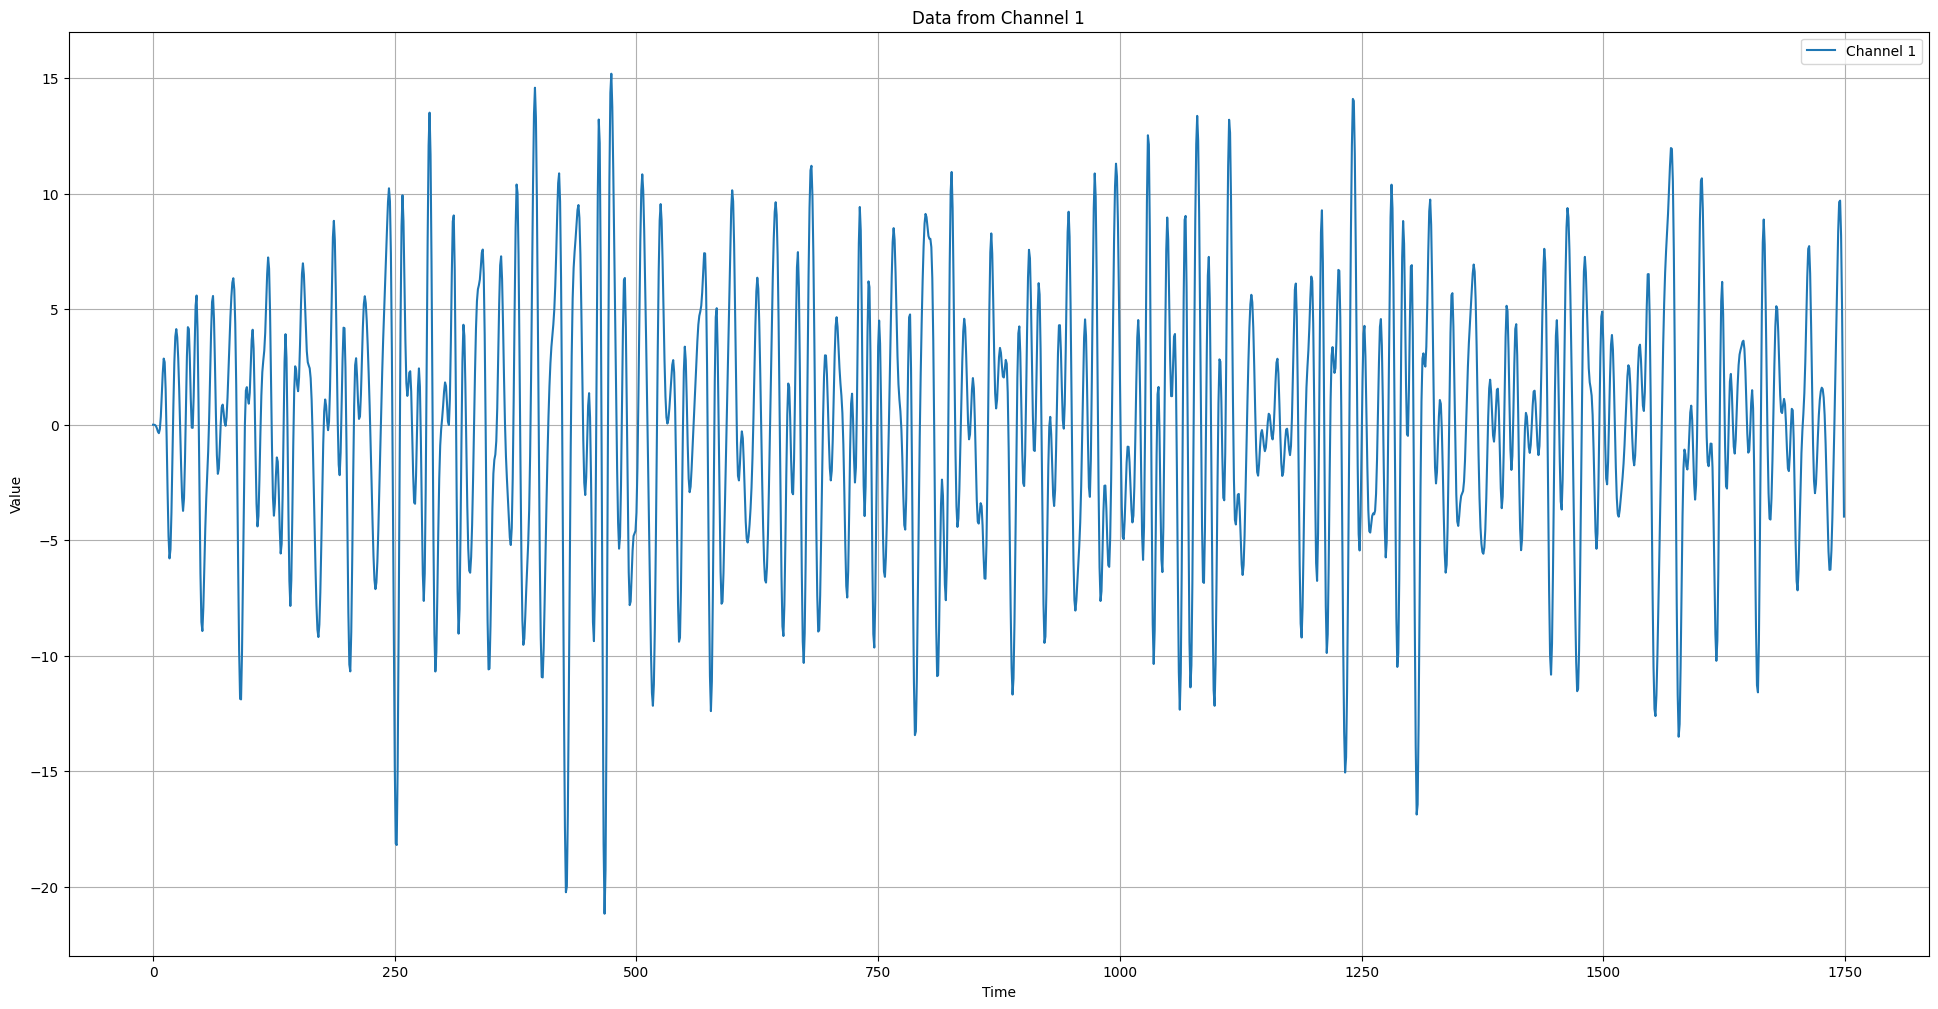

In [8]:
plt.figure(figsize=(24, 12))
plt.plot(x[1][0], label=f'Channel {1}')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Data from Channel 1')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
import mne
info = mne.create_info(ch_names=['c1', 'c2', 'c3','c4','c5', 'c6', 'c7','c8'], sfreq=250., ch_types='eeg')
train = mne.EpochsArray(x, info=info)
print(train)

Not setting metadata
2967 matching events found
No baseline correction applied
0 projection items activated
<EpochsArray |  2967 events (all good), 0 – 6.996 s, baseline off, ~316.9 MB, data loaded,
 '1': 2967>


In [10]:
from braindecode.models.util import models_dict

print(f'All the Braindecode models:\n{list(models_dict.keys())}')

All the Braindecode models:
['ATCNet', 'Deep4Net', 'DeepSleepNet', 'EEGConformer', 'EEGITNet', 'EEGInception', 'EEGInceptionERP', 'EEGInceptionMI', 'EEGNetv1', 'EEGNetv4', 'EEGResNet', 'HybridNet', 'ShallowFBCSPNet', 'SleepStagerBlanco2020', 'SleepStagerChambon2018', 'SleepStagerEldele2021', 'TCN', 'TIDNet', 'USleep']


In [14]:
from skorch.dataset import ValidSplit
from braindecode import EEGClassifier
from skorch.callbacks import LRScheduler
import torch
import random
seed = random.randint(1, 100000)
torch.manual_seed(seed)

n_epochs = 100
print("Seed", seed)
net = EEGClassifier(
    "EEGITNet",
    # module__final_conv_length='auto',
    optimizer=torch.optim.AdamW,
    train_split=ValidSplit(0.2, random_state=seed),
    max_epochs=n_epochs,
    device='cuda',
    verbose=-1,
    callbacks=["f1_macro",("lr_scheduler", LRScheduler("CosineAnnealingLR", T_max=n_epochs - 1)),],
    criterion=torch.nn.CrossEntropyLoss,
    # To train a neural network you need validation split, here, we use 20%.
)

Seed 83440


In [15]:
#encode 110 -> 0(left), 120 -> 1(right), 150 -> 2(rest)
y[y == 110] = 0
y[y == 120] = 1
y[y == 150] = 2
y

array([1, 0, 1, ..., 1, 0, 2])

In [16]:
net.fit(train, y)

  epoch    train_f1_macro    train_loss    valid_acc    valid_f1_macro    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.3664        1.4245       0.3215            0.2883        1.1735  0.0100  0.7743
      2            0.4148        1.3694       0.3569            0.3551        1.1502  0.0100  0.5329
      3            0.4203        1.2555       0.3165            0.2972        1.1584  0.0100  0.5220
      4            0.4350        1.2328       0.3603            0.3285        1.1407  0.0100  0.5150
      5            0.4945        1.1368       0.3721            0.3612        1.1194  0.0100  0.5132
      6            0.5251        1.1308       0.3771            0.3736        1.1012  0.0099  0.5232
      7            0.4777        1.1127       0.3956            0.3597        1.1197  0.0099  0.5266
      8            0.5291        1.0561       0.3754            0.3649        1.0960  0.009

<class 'braindecode.classifier.EEGClassifier'>[initialized](
  module_=======================================================================================================================================================
  Layer (type (var_name):depth-idx)                  Input Shape               Output Shape              Param #                   Kernel Shape
  EEGITNet (EEGITNet)                                [1, 8, 1750]              [1, 3]                    --                        --
  ├─Sequential (input_preprocess): 1-1               [1, 8, 1750]              [1, 1, 8, 1750]           --                        --
  │    └─Ensure4d (0): 2-1                           [1, 8, 1750]              [1, 8, 1750, 1]           --                        --
  │    └─Rearrange (1): 2-2                          [1, 8, 1750, 1]           [1, 1, 8, 1750]           --                        --
  ├─_InceptionBlock (inception_block): 1-2           [1, 1, 8, 1750]           [1, 14, 1, 1750]   

In [17]:
import os
import pandas as pd

# Specify the directory
directory = 'brain-motor-imagery-classification/test'
sub = pd.read_csv("brain-motor-imagery-classification/sample_submission.csv")
list_path=[]
# List all files in the directory
files = os.listdir(directory)

# Loop through the files and read them
for i in sub["id"]:
    file_path = os.path.join(directory, i+".npy")
    
    # Check if it's a file (and not a directory)
    if os.path.isfile(file_path):
        xa = np.load(file_path)
        list_path.append(xa)

In [18]:
nub_xx = []
n = 0
i= 0 
for segment in tqdm(list_path):
    segment = segment.astype(np.float64)
    segment = kurtosis_ica_method(segment)
    signals = []
    for channel in range(segment.shape[1]):
        signals.append(butter_bandpass_filter(segment[:, channel], 10, 22, 250))

    segment = np.vstack(signals).T
    
    nub_x.append(sigals.swapaxes(1,0))#segment.swapaxes(1,0))
    if segment.shape[0]== 1751:
        flattened_array = segment.flatten()
        trimmed_array = flattened_array[:-17]
        reshaped_array = trimmed_array.reshape(1750, 17)
        nub_xx.append(reshaped_array.swapaxes(1,0))
    elif segment.shape[0]== 1752:
        flattened_array = segment.flatten()
        trimmed_array = flattened_array[:-34]
        reshaped_array = trimmed_array.reshape(1750, 17)
        nub_xx.append(reshaped_array.swapaxes(1,0))
    else:
        nub_xx.append(segment.swapaxes(1,0))


100%|██████████| 480/480 [02:09<00:00,  3.72it/s]


In [19]:
len(nub_xx)

480

In [20]:
test_set = np.stack(nub_xx, axis=0)
test_set = test_set[:, :8, :1750]

In [21]:
test_set.shape

(480, 8, 1750)

In [22]:
def Create_Epochs_Array(x):
    info = mne.create_info(ch_names=['c1', 'c2', 'c3','c4', 'c5', 'c6', 'c7', 'c8'], sfreq=250., ch_types='eeg')
    y = mne.EpochsArray(x, info=info,baseline=(None, None))
    return y

In [23]:
test = Create_Epochs_Array(test_set)

Not setting metadata
480 matching events found
Setting baseline interval to [0.0, 6.996] s
Applying baseline correction (mode: mean)
0 projection items activated


In [24]:
test

Number of events,480
Events,1: 480
Time range,0.000 – 6.996 s
Baseline,0.000 – 6.996 s


In [25]:
pre = net.predict(test)

In [26]:
pre[:3]

array([2, 2, 2], dtype=int64)

In [27]:
pre[pre == 0] = 110
pre[pre == 1] = 120
pre[pre == 2] = 150

In [28]:
count1 = np.count_nonzero(pre == 110)
count2 = np.count_nonzero(pre == 120)
count3 = np.count_nonzero(pre == 150)
print(count1,count2,count3)

99 223 158


In [29]:
sub["predict"].iloc[3:] = pre[3:]
sub.to_csv(f'seed{seed}.csv', index=False)

In [118]:
net

<class 'braindecode.classifier.EEGClassifier'>[initialized](
  module_=======================================================================================================================================================
  Layer (type (var_name):depth-idx)                  Input Shape               Output Shape              Param #                   Kernel Shape
  EEGITNet (EEGITNet)                                [1, 8, 1750]              [1, 3]                    --                        --
  ├─Sequential (input_preprocess): 1-1               [1, 8, 1750]              [1, 1, 8, 1750]           --                        --
  │    └─Ensure4d (0): 2-1                           [1, 8, 1750]              [1, 8, 1750, 1]           --                        --
  │    └─Rearrange (1): 2-2                          [1, 8, 1750, 1]           [1, 1, 8, 1750]           --                        --
  ├─_InceptionBlock (inception_block): 1-2           [1, 1, 8, 1750]           [1, 14, 1, 1750]   

In [30]:
import pickle

with open('model.pkl', 'wb') as f:
    pickle.dump(net, f)

In [31]:
with open('model.pkl', 'rb') as f:
    eiei = pickle.load(f)

In [32]:
eiei.predict(test)

array([2, 2, 2, 0, 1, 0, 2, 1, 2, 1, 2, 2, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0,
       1, 1, 1, 1, 2, 2, 0, 0, 1, 1, 0, 2, 1, 1, 1, 2, 1, 1, 2, 0, 0, 2,
       2, 1, 1, 1, 1, 1, 2, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 1, 1, 2, 2, 1, 1, 0, 2, 2, 1, 1,
       1, 2, 2, 1, 1, 1, 1, 0, 2, 2, 2, 2, 0, 1, 0, 1, 1, 0, 2, 0, 0, 2,
       2, 2, 1, 0, 1, 2, 0, 2, 2, 0, 1, 0, 1, 1, 1, 1, 2, 1, 2, 0, 2, 0,
       1, 1, 2, 0, 1, 2, 1, 2, 1, 1, 1, 1, 0, 1, 1, 1, 2, 0, 1, 0, 0, 2,
       0, 1, 0, 2, 0, 2, 2, 2, 2, 2, 1, 2, 1, 2, 0, 1, 2, 1, 2, 2, 1, 0,
       2, 2, 0, 2, 1, 1, 1, 1, 2, 0, 1, 1, 2, 2, 2, 2, 1, 1, 2, 0, 1, 2,
       0, 1, 2, 1, 2, 2, 2, 1, 0, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1,
       0, 0, 2, 1, 1, 1, 2, 0, 1, 2, 1, 1, 1, 1, 1, 2, 1, 0, 1, 0, 1, 2,
       1, 1, 2, 2, 0, 1, 2, 1, 1, 0, 1, 0, 1, 2, 2, 2, 1, 1, 0, 1, 2, 0,
       2, 2, 1, 0, 1, 2, 2, 2, 2, 2, 1, 1, 1, 0, 1, 2, 2, 1, 1, 1, 1, 1,
       2, 0, 0, 2, 1, 1, 2, 1, 1, 0, 2, 2, 2, 2, 1,